<a href="https://colab.research.google.com/github/joseduardogon/AlzheimerDetection/blob/main/CNN_Alzheimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code by: **Jose Eduardo Gontijo de Carvalho** e
         **Khalil Alves Motta**

# ***Introdução***

---




> No Brasil, segundo dados de 2021, 1,2 milhão de pessoas vivem com alguma forma de demência e em torno de 100 mil novos casos são diagnosticados por ano. No mundo, cerca de 50 milhões de pessoas vivem com a doença e, segundo estimativas da Alzheimer's Disease International(ADI), até 2050 o número de pessoas afetadas deve triplicar.

>Diante desse panorama, é notável a importância de um diagnóstico antecipado e formas eficientes de identificar precisamente a doença, com finalidade de retardar o avanço e estimular medidas preventivas para as pessoas acometidas.

>Nesse contexo, este projeto tem como objetivo desenvolver uma CNN(rede neural convolucional) que, através de imagens de ressonância magnética do cérebro de pacientes, seja capaz de identificar a presença de demência e a classificar em 4 grupos distintos, sendo eles:


*   Sem demência
*   Demência muito leve
*   Demência leve
*   Demência moderada

>Se bem sucedida, a rede neural seria capaz de auxiliar o trabalho de inúmeros médicos e contribuir para uma "linha de produção" mais eficiente dentro dos hospitais, em especial os que fazem parte da rede pública.

# ***Formulação do problema e objetivos***

>Para o desenvolvimento dessa rede neural, foi utilizado um banco dados com 6400 imagens de ressonância magnética do cérebro de diferentes pacientes(Disponível em https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset). O banco de dados é composto por imagens de formato .jpg com resolução de 128 x 128 pixels. Dessas 6400 amostras, 3200 pertencem a classe de pessoas sem demência, 2240 a classe de demência muito leve, 896 a classe de demência leve e 64 a classe de demência moderada.

>Como apontado previamente, o objetivo da rede neureal é, através de uma imagem de ressonância magnética, conseguir determinar precisamente o grau de demência, caso ele exista, de um paciente. A arquitetura convolucional foi escolhida devido a sua melhor perfomance para treinamento de modelos que envolvem processamento de imagens.




In [24]:
#importando bibliotecas

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ***Metodologia e desenvolvimento do código da CNN***

In [25]:
#fazendo download do dataset do kaggle

! pip install kaggle

import subprocess

subprocess.run(['icacls', 'C:\\Users\\josed\\.kaggle\\kaggle.json', '/grant:r', 'josed:(w)'])



Defaulting to user installation because normal site-packages is not writeable


CompletedProcess(args=['icacls', 'C:\\Users\\josed\\.kaggle\\kaggle.json', '/grant:r', 'josed:(w)'], returncode=0)

In [26]:
#fazendo download do dataset
! kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset

alzheimer-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [27]:
import zipfile

with zipfile.ZipFile('alzheimer-mri-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall(r'g:\My Drive\UFG\2 Periodo\IA\Trabalho pratico\vscode')


# ***Exemplo de cada tipo de Instancia a ser aprendida pelo modelo***

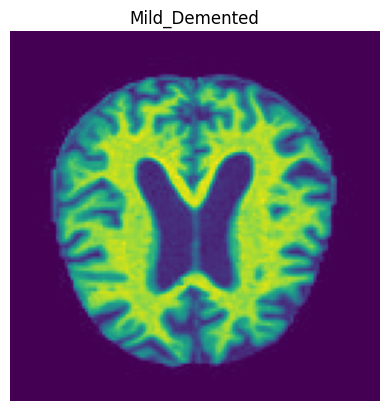

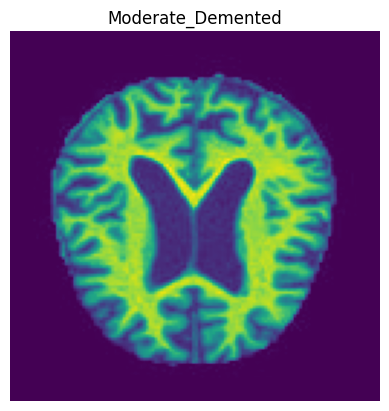

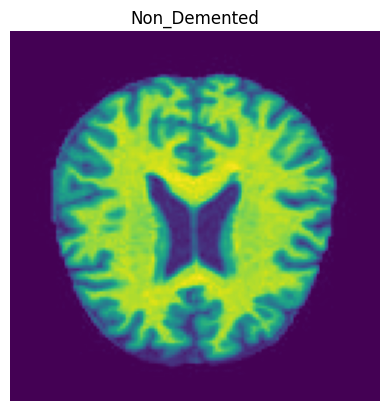

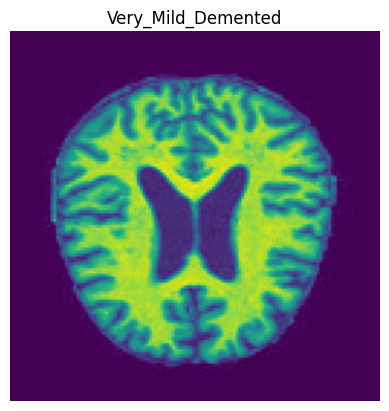

In [28]:
#exibindo um exemlpo de imagem para cada uma das 4 classes
import os
from PIL import Image

base_path = r"g:\My Drive\UFG\2 Periodo\IA\Trabalho pratico\vscode\Dataset"
classes = os.listdir(base_path)

# Exibir uma imagem pra cada classe
for class_name in classes:
    class_path = os.path.join(base_path, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

    # Exibe a primeira imagem pra cada classe
    if len(image_files) > 0:
        image_path = os.path.join(class_path, image_files[0])
        image = Image.open(image_path)

        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')
        plt.show()

#***Divisão dos dados***
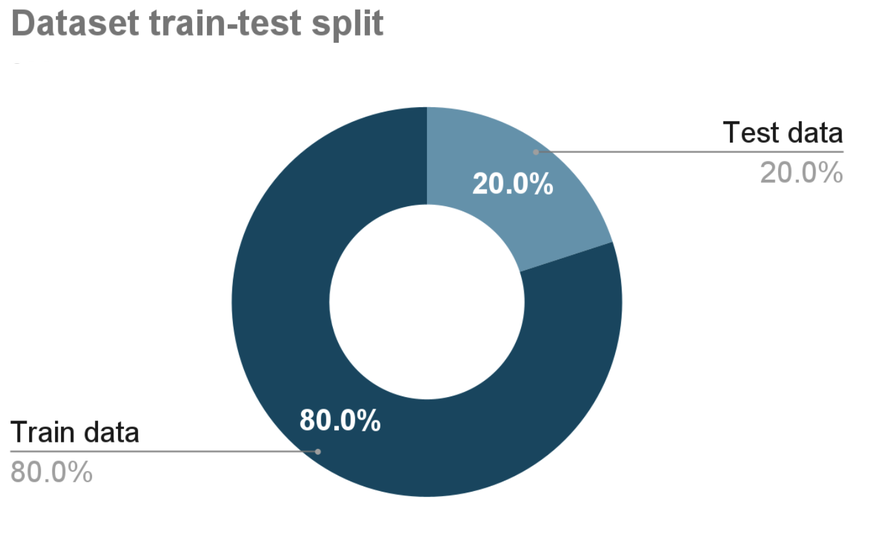

In [30]:
#Carregando e dividindo o dataset em Treino e Teste

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    r"g:\My Drive\UFG\2 Periodo\IA\Trabalho pratico\vscode\Dataset",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    r"g:\My Drive\UFG\2 Periodo\IA\Trabalho pratico\vscode\Dataset",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


# ***Criando e treinando a CNN***

In [31]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model

# Carregar EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Modificar a primeira camada convolucional para um input menor
base_model.layers[0].kernel_size = (3, 3)
base_model.layers[0].strides = (1, 1)

# Adicionar as camadas modificadas
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)

# Criar o modelo
model = Model(inputs=base_model.input, outputs=output)




16705208/16705208 [==============================] - 2s 0us/step


In [32]:
# Compilar e preparar os dados para treinamento
model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 4, 4, 1280)        4049571   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 batch_normalization (Batch  (None, 20480)             81920     
 Normalization)                                                  
                                                                 
 dense_2 (Dense)             (None, 256)               5243136   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 

In [33]:
#treinamento
history = model.fit(x= train_data, epochs= 50, verbose= 0,
                     validation_data= test_data, validation_steps= None, shuffle= False)

In [34]:
model.save_weights(r"g:\My Drive\UFG\2 Periodo\IA\Trabalho pratico\vscode\Dataset")

In [36]:
model.load_weights(r"g:\My Drive\UFG\2 Periodo\IA\Trabalho pratico\vscode\Dataset")


In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 4, 4, 1280)        4049571   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 batch_normalization (Batch  (None, 20480)             81920     
 Normalization)                                                  
                                                                 
 dense_2 (Dense)             (None, 256)               5243136   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1

# ***Graficos de Treinamento e Validacao***

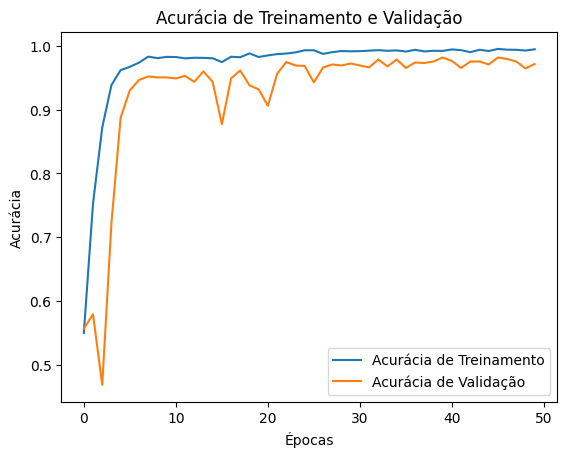

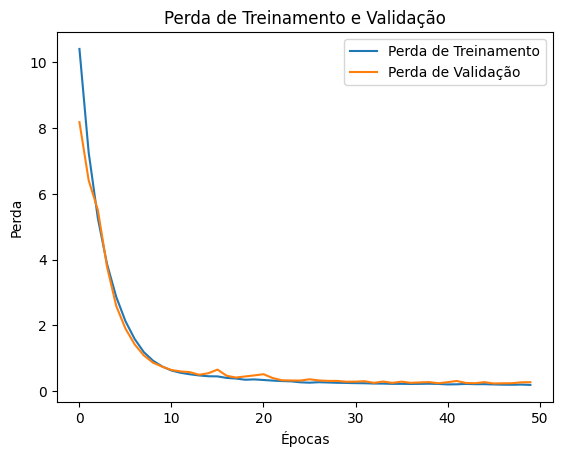

In [38]:
import matplotlib.pyplot as plt

#Plotar a acurácia de treinamento e validação por época
plt.figure()
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia de Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

#Plotar a perda de treinamento e validação por época
plt.figure()
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda de Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()


# ***Matriz de Confusao***

2/2 [==============================] - 0s 40ms/step


Text(95.72222222222221, 0.5, 'Verdadeiro')

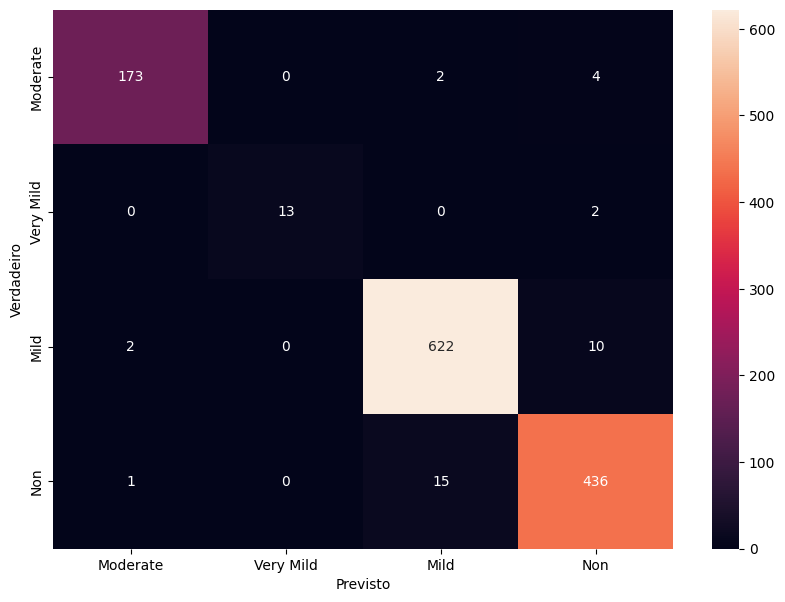

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Inicializar listas vazias para armazenar os rótulos verdadeiros e previstos
y_test_classes = []
y_pred_classes = []

# Iterar sobre os dados de teste
for images, labels in test_data:
    # Adicionar os rótulos verdadeiros à lista y_test_classes
    y_test_classes.extend(np.argmax(labels.numpy(), axis=1))

    # Usar o modelo para fazer previsões
    y_pred = model.predict(images)

    # Adicionar as previsões à lista y_pred_classes
    y_pred_classes.extend(np.argmax(y_pred, axis=1))

# Calcular a matriz de confusão
cm = confusion_matrix(y_test_classes, y_pred_classes)

import pandas as pd

# Definir os rótulos das classes
class_labels = ['Moderate', 'Very Mild', 'Mild', 'Non']

# Criar um DataFrame para a matriz de confusão com rótulos de classe
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')



# ***Metricas de Desempenho***

In [42]:
from sklearn.metrics import classification_report

# Use o modelo para fazer previsões nos dados de teste
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Iterar sobre os dados de teste para obter os rótulos verdadeiros
y_test_classes = []
for images, labels in test_data:
    y_test_classes.extend(np.argmax(labels.numpy(), axis=1))

# Calcular a perda e a acurácia usando a função evaluate()
loss, accuracy = model.evaluate(test_data)

# Calcular a precisão, o recall e o F1-score
report = classification_report(y_test_classes, y_pred_classes, target_names=class_labels)

print('Perda:', loss)
print('Acurácia:', accuracy)
print('Relatório de Classificação:\n', report)



32/32 [==============================] - 8s 219ms/step - loss: 0.2748 - accuracy: 0.9719
Perda: 0.2748103737831116
Acurácia: 0.971875011920929
Relatório de Classificação:
               precision    recall  f1-score   support

    Moderate       0.10      0.10      0.10       179
   Very Mild       0.00      0.00      0.00        15
        Mild       0.50      0.50      0.50       634
         Non       0.35      0.35      0.35       452

    accuracy                           0.39      1280
   macro avg       0.24      0.24      0.24      1280
weighted avg       0.39      0.39      0.39      1280



# ***Exemplos de Resultados das Previsoes***



2/2 [==============================] - 0s 45ms/step


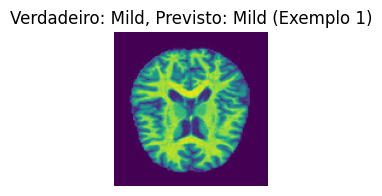

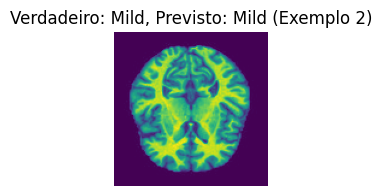

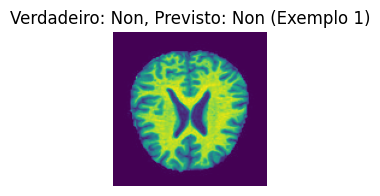

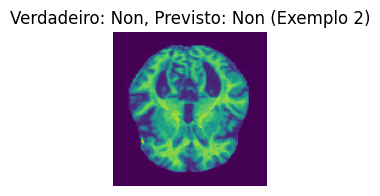

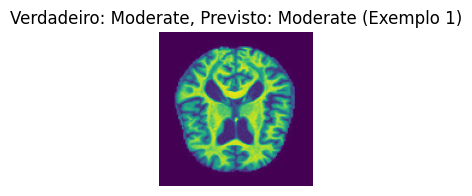

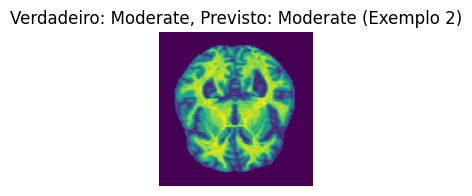

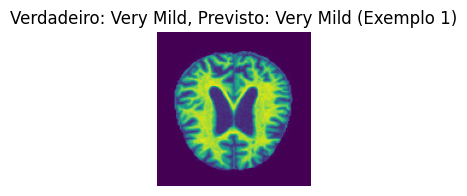

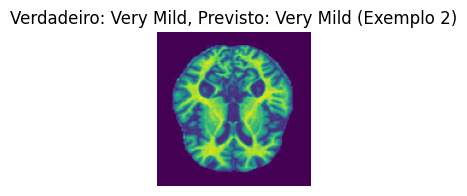

In [44]:
# Inicializar um dicionário para armazenar dois exemplos de cada classe
examples = {}

# Iterar sobre os dados de teste
for images, labels in test_data:
    # Use o modelo para fazer previsões
    predictions = model.predict(images)

    # Obter os rótulos de classe previstos e verdadeiros
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    # Adicionar dois exemplos de cada classe ao dicionário
    for i in range(len(true_classes)):
        if true_classes[i] not in examples:
            examples[true_classes[i]] = [(images[i], predicted_classes[i])]
        elif len(examples[true_classes[i]]) < 2:
            examples[true_classes[i]].append((images[i], predicted_classes[i]))

    # Parar quando tivermos dois exemplos de cada classe
    if all(len(examples.get(i, [])) == 2 for i in range(4)):
        break

# Plotar dois exemplos de cada classe
for true_class, example_list in examples.items():
    for i, (image, predicted_class) in enumerate(example_list):
        plt.figure(figsize=(2, 2))
        plt.imshow(image.numpy().astype('uint8'))
        plt.title(f"Verdadeiro: {class_labels[true_class]}, Previsto: {class_labels[predicted_class]} (Exemplo {i+1})")
        plt.axis('off')

